# Beyond Images: Word Embeddings

So far, we have almost exclusively used images. We have classified them and we have generated them. How about text? At the end, a text is a time-series of ASCII characters, and we could surely train pattern detectors and generators on them. Grammar is a lot less forgiving then graphics, however, and a slightly different shade of gray that might go unobserved in an image, might make a text unreafable (unreadable). In some applications such as translation, text understanding or generation it might therefore make sense to rely on words, not characters, as the smallest digestible unit. A naive approach would be to create a dictionary in which words are represented by integer values. These in turn can be represented by one-hot encoding:

- the   1 00000001
- quick 2 00000010
- brown 3 00000100
- fox   4 00001000
- jumps 5 00010000
- over  6 00100000
- lazy  7 01000000
- dog   8 10000000

This is costly, as vectors get very long. (Remember, softmax activation requires to sum over all outputs, e.g.) In particular, $N$-dimensional integers are turned into $N$ dimensional vector space.  

One way to reduce the dimensionality of one-hot encoding would be to project data into a lower dimensional vector space. This is known as <i>embedding</i> and is a standard layer in Keras.

## Word embeddings

In its most simplest form, embedding $N$ values into $M$-dimensional vectors could be done by generating $N$ random $M$-dimensional vectors. The embedding layer would simply serve as a look-up table. This can be seen in the keras code below. In our example, $N=8$ and $M=3$ would generate a 3-dimensional embedding. Here <code>input_length</code> refers to the number of integers that will be provided to the embedding layer at a time, here one integer results in three values, two integers into six and so on.

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np

model = Sequential()
embedding_layer = Embedding(input_dim=8, output_dim=3, input_length=1)
model.add(embedding_layer)
model.compile('adam', 'mse') # will need to provide an optimizer and loss, even though not used here

In [56]:
def print_embedding_weights():
    for I in range(8):
        input_data = np.array(I).reshape(1,1) # turn into one sample with one data point
        #input_data = np.array([1,2]).reshape(1,2) # example for input length two

        pred = model.predict(input_data)
        print(pred)

print_embedding_weights()

[[[ 0.03080323 -0.00436597 -0.03693813]]]
[[[ 0.03868173 -0.04781219 -0.034648  ]]]
[[[ 0.04200144 -0.04283803  0.00865404]]]
[[[ 0.02593631 -0.02306879  0.02608968]]]
[[[ 0.00375088 -0.01421449 -0.01163588]]]
[[[-0.02737376 -0.00066825  0.02329269]]]
[[[ 0.03849734  0.01492298 -0.01914817]]]
[[[ 0.02770283 -0.03706833  0.02405379]]]


Note that "one-hot" encoding can also be an embedding, allowing us to integrate the preprocessing step into the network itself. This can be seen when manually defining the weights of the embedding layer.

In [52]:
embedding_lookup = np.array([
    [1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,1,0,0,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1],
])

model = Sequential()
embedding_layer = Embedding(input_dim=8, output_dim=8, input_length=1)
model.add(embedding_layer)
model.compile('adam', 'mse')

embedding_layer.set_weights([embedding_lookup])

print_embedding_weights()

[[[1. 0. 0. 0. 0. 0. 0. 0.]]]
[[[0. 1. 0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 1. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 1. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 1. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 1. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0. 1. 0.]]]
[[[0. 0. 0. 0. 0. 0. 0. 1.]]]


It is clear now how an array of words can be mapped to an integer number (the index into the array). We can also see how to find the index of any given vector. When using one-hot encoding, we use a softmax activation layer and then find the index that yields the highest entry in the softmax vector (arg max). When searching over vectors consisting of random numbers, this step is a little more involved, requiring us to find the vector with the least distance, for example using the cosine distance (dot product), given by

$$  \cos(\theta)=\frac{AB}{\|A\|\|B\|} $$

for the vectors $A$ and $B$. When vectors are the same, the angle inbetween them is zero. If they are orthogonal, the angle is 90 degrees and they are very dissimilar. 

# word2vec

Assuming we have a neural network that is able to generate words, the cosine distance will allow us finding the closest word in the dictionary. It would therefore be advantagous if the entire embedding would be organized so that closely related words would have similar distances. Having such a corpus would not allow representing texts in a lower dimensional space that can be processed by a standard neural network architecture, but also provide a natural way to capture different expressions that mean the same thing. Here, we can take advantage of the fact that embeddings can also be trained to minimize a loss function that is added to the network.

A technique that does this, is known as <i>word2vec</i>. Instead of manually annotating similarities between words and thinking up a coding scheme, we smartly design a neural network that generates the desired result - a $M$-dimensional vector that represents each one of $N$ words - as a side-effect of training an appropriate problem. In other words, we take advantage of the fact that dense neural networks automatically create internal representations that we can literally scoop off.

One such a network, known as the <i>skip-gram</i> word2vec model, is a model that predicts words that could, or often are, surrounding another word. For example, the sentence

<i>The quick brown fox jumps over the lazy dog</i>

creates the following associations

- the <-> quick
- quick <-> brown
- brown <-> fox
- fox <-> jumps

and so on. We can also train a classifier, that would tell us, whether one word is likely to be next to another by creating the following training set

- ((The, quick),1)
- ((quick, brown),1)
- ((brown, fox),1)

We would also need to create negative examples, for example by adding random words from this or another corpus:

- ((quick, dog),0)
- ((brown, dog), 0)
- ((quick, zebra), 0)

The goal is now to train a network so that words that are likely to follow each other get a high score (1), and words that are never in the same context get a very low score (0). One way to accomplish tis is to design a network that uses the <i>same</i> embedding to encode both word and context word. Words (word and context) are embedded into a 300-dimensional row vector and reshaped into a 300-dimensional column vector in parallel. A so-called <a href="https://keras.io/layers/merge/">merge layer</a>, here the dot product, then normalizes the two data streams and combines them into a single scalar. The result is that the dot-product layer effectively compares input and context word.



Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 3)         30          input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
reshape_23 (Reshape)            (None, 3, 1)         0           embedding[0][0]            

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


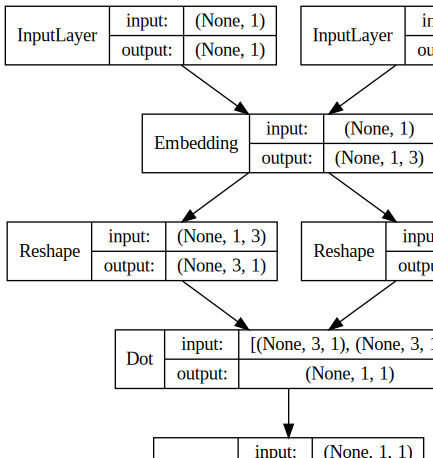

In [156]:
vocab_size = 10
embed_size = 3

from keras.layers import Input
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape
from keras.layers import dot

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding') # Define Embedding() only once so that both word and context are using the same embedding. 

word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)
context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1, normalize=True)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model(input=[input_target, input_context], output=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

The model above will find an embedding in which words that are appearing next to another in a text are represented by vectors that have a smaller distance than vectors of words that never appear next to each other. In order to train such a model, we have to generate appropriate skipgrams for training.

In [157]:
from keras.preprocessing.text import *
from keras.preprocessing.sequence import skipgrams

text = "The quick brown fox jumps over the lazy dog"

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

wids = [word2id[w] for w in text_to_word_sequence(text)]
pairs, labels = skipgrams(wids, len(word2id), window_size=1)
print("Number of pairs: ",len(pairs))
for i in range(20):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

Number of pairs:  32
(over (6), jumps (5)) -> 1
(dog (8), lazy (7)) -> 1
(brown (3), quick (2)) -> 1
(lazy (7), dog (8)) -> 1
(the (1), over (6)) -> 1
(the (1), quick (2)) -> 0
(over (6), brown (3)) -> 0
(quick (2), brown (3)) -> 1
(fox (4), jumps (5)) -> 1
(the (1), lazy (7)) -> 1
(jumps (5), over (6)) -> 1
(the (1), lazy (7)) -> 0
(jumps (5), over (6)) -> 0
(the (1), lazy (7)) -> 0
(quick (2), quick (2)) -> 0
(lazy (7), the (1)) -> 1
(brown (3), fox (4)) -> 1
(fox (4), brown (3)) -> 0
(quick (2), over (6)) -> 0
(brown (3), over (6)) -> 0


In [161]:
from numpy import asarray
history=model.fit([asarray(pairs)[:,0], asarray(pairs)[:,1]],labels,epochs=200,verbose=0)
model.evaluate([asarray(pairs)[:,0], asarray(pairs)[:,1]],labels, verbose=0)

0.11477307975292206

In [162]:
embedding.get_weights()

[array([[-0.03853421, -0.01923045, -0.03822639],
        [-0.00731206, -0.13755003,  0.12676875],
        [-0.01641215,  0.12862098,  0.06812601],
        [-0.09955261,  0.0113467 , -0.2285318 ],
        [-0.00181953,  0.14252363,  0.06642576],
        [-0.08305285, -0.09567424, -0.07200117],
        [ 0.03106353,  0.1278866 , -0.09797202],
        [-0.17730547,  0.06396743, -0.0027189 ],
        [ 0.1971729 ,  0.01422863, -0.05654199],
        [-0.02735932, -0.00215567, -0.01546366]], dtype=float32)]

We can now store this embedding and later use it to encode words from a text. This is yet another application of transfer learning and good embeddings are costly to produce and tremendously useful. For example, google provides a word2vec embedding training on a large amount of news articles. A iPython notebook demonstrating this can be found here

https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_11_02_word2vec.ipynb

Why using a pre-trained embedding makes sense becomes more obvious when considering a task of classifying online ratings. While the meaning of individual words can surely be learned from a large enough corpus using a word2vec embedding will also allow us to deal with ratings that use novel words with similar meaning, e.g. For example, the most similar words to "tasty" in the google news dataset are

In [1]:
[('delicious', 0.8730389475822449),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856924533843994),
 ('flavorful', 0.7420164346694946),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012300491333008),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857702732086182)]

[('delicious', 0.8730389475822449),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856924533843994),
 ('flavorful', 0.7420164346694946),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012300491333008),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857702732086182)]

and it is likely that similar sentences with such a word instead of "tasty" w

# Observations

- We have shown "embeddings" in the context of words as lanugage usually has a lot of them and a more direct encoding is infeasible. Embeddings do work in any of these situations in which a dimensionality reduction of otherwise discrete classes is desired.

- We have also seen that embeddings can be learned to encode desired properties, such as similarity between individual elements. This can be learned by using Keras' "merge" layers, and in particular the dot product. Merge layers are a powerful method to create interesting new systems. For example, a "concatenate" layer can be used to merge networks with different kinds of input. For example, a house's price might be predicted from statistical data as well as images, see for example https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/.